In [3]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # conv1, 加padding扩充成32*32
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # conv2
        self.conv2 = nn.Conv2d(6, 16, 5)
    
        # fc
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # conv --> relu --> maxpool
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # num_flat_feaures = 16*16*5
        x = x.view(-1, self.num_flat_features(x))
        
        # fc1 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
        
        

100.1%

Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw


113.5%

Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw


100.4%

Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw


180.4%D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw
Processing...
Done!


D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


train size torch.Size([60000, 28, 28])
train label size torch.Size([60000])


D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


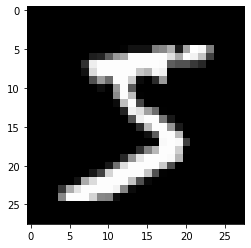

In [4]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

EPOCH = 10               # 训练epoch次数
BATCH_SIZE = 64          # 批训练的数量
LR = 0.001               # 学习率      

train_data = datasets.MNIST(root='./mnist/', train=True,transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./mnist/', train=False,transform=transforms.ToTensor(), download=True)


test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255
test_y = test_data.test_labels.numpy()[:2000]

import matplotlib.pyplot as plt
%matplotlib inline

print("train size", train_data.train_data.size())
print("train label size", train_data.train_labels.size())

plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.show()


In [5]:
# 使用dataloader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# model
model = LeNet5()
# loss functino
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# train
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # gpu use
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        # loss
        loss = criterion(outputs, labels)
        # zero_grad
        optimizer.zero_grad()
        # backward
        loss.backward()
        # step 参数更新
        optimizer.step()
        
    # 为什么用item，因为loss只有一个数值
    print('epoch{} loss:{:.4f}%'.format(epoch+1, loss.item()))



epoch1 loss:0.0306%
epoch2 loss:0.0362%
epoch3 loss:0.0569%
epoch4 loss:0.1371%
epoch5 loss:0.0015%
epoch6 loss:0.1058%
epoch7 loss:0.0060%
epoch8 loss:0.0004%
epoch9 loss:0.0466%
epoch10 loss:0.0091%


In [27]:
# 保存模型
torch.save(model, 'mnist_lenet5.pt')
model = torch.load('mnist_lenet5.pt')

# 测试
model.eval()
correct = 0
total = 0

# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model.fc1.register_forward_hook(get_activation('fc1'))

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    # forward
    out = model(images)
#     # 查看中间层输出
#     print((activation['fc1']))
    _, predicted = torch.max(out.data, 1)
    total = total + labels.size(0)
    correct += (predicted==labels).sum().item()
    
# correct 
print('10000 test correct:{:.4f}%'.format(100*correct/total))

AttributeError: Can't pickle local object 'get_activation.<locals>.hook'

In [18]:
import torch
model = torch.load('mnist_lenet5.pt')
print(model.load_state_dict)
print(model.fc3.weight)
# print(30*"*"+" total " + 30*"*")
# print(model.load_state_dict)
# print(30*"*"+" conv1 " + 30*"*")
# print(model.conv1.weight.size())
# print(model.conv1.weight)
# print(model.conv1.bias.size())
# print(30*"*"+" conv2 " + 30*"*")
# print(model.conv2.weight.size())
# print(model.conv2.bias.size())
# print(30*"*"+" fc1 " + 30*"*")
# print(model.fc1.weight.size())
# print(model.fc1.bias.size())
# print(30*"*"+" fc2 " + 30*"*")
# print(model.fc2.weight.size())
# print(model.fc2.bias.size())

<bound method Module.load_state_dict of LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>
Parameter containing:
tensor([[ 3.3270e-02, -1.7707e-01, -3.9913e-02, -7.7015e-03, -1.4851e-01,
          2.5459e-01, -8.6036e-02,  1.4460e-01, -2.9920e-02, -4.5989e-02,
         -3.0611e-01,  9.8063e-02,  2.2010e-03,  7.7754e-02,  1.0695e-01,
          3.0505e-02, -2.3469e-01, -3.5094e-01, -4.7687e-02, -1.3206e-01,
         -2.7678e-01, -1.9024e-01,  1.0222e-01, -1.8522e-02,  5.0097e-02,
         -2.0001e-01, -1.3214e-01,  3.0613e-02,  2.8291e-02,  1.7169e-01,
          1.3392e-01,  1.4378e-01, -2.1543e-01, -1.0580e-01,  2.5260e-02,
         -1.1382e-01, -5.3899e-02,  6.5151e-03,  1.4884e-02,  3.6829e-02,
          1.9558e

In [11]:
def Record_Tensor(tensor,name):
	print ("Recording tensor "+name+" ...")
	f = open('./record/mnist_lenet5/'+name+'.dat', 'w')
	array=tensor.cpu().detach().numpy();
	#print ("The range: ["+str(np.min(array))+":"+str(np.max(array))+"]")
	print("shape:{}".format(np.shape(array)))
	if(np.size(np.shape(array))==1):
		Record_Array1D(array,name,f)
	else:
		if(np.size(np.shape(array))==2):
			Record_Array2D(array,name,f)
		else:
			if(np.size(np.shape(array))==3):
				Record_Array3D(array,name,f)
			else:
				Record_Array4D(array,name,f)
	f.close();

def Record_Array1D(array,name,f):
	for i in range(np.shape(array)[0]):
		f.write(str(array[i])+"\n");

def Record_Array2D(array,name,f):
	for i in range(np.shape(array)[0]):
		for j in range(np.shape(array)[1]):
			f.write(str(array[i][j])+"\n");

def Record_Array3D(array,name,f):
	for i in range(np.shape(array)[0]):
		for j in range(np.shape(array)[1]):
			for k in range(np.shape(array)[2]):
				f.write(str(array[i][j][k])+"\n");

def Record_Array4D(array,name,f):
	for i in range(np.shape(array)[0]):
		for j in range(np.shape(array)[1]):
			for k in range(np.shape(array)[2]):
				for l in range(np.shape(array)[3]):
					f.write(str(array[i][j][k][l])+"\n");

In [14]:
Record_Tensor(model.conv1.weight,"W_conv1")
Record_Tensor(model.conv1.bias,"b_conv1")
Record_Tensor(model.conv2.weight,"W_conv2")
Record_Tensor(model.conv2.bias,"b_conv2")
Record_Tensor(model.fc1.weight,"W_fc1")
Record_Tensor(model.fc1.bias,"b_fc1")
Record_Tensor(model.fc2.weight,"W_fc2")
Record_Tensor(model.fc2.bias,"b_fc2")
Record_Tensor(model.fc3.weight,"W_fc3")
Record_Tensor(model.fc3.bias,"b_fc3")

Recording tensor W_conv1 ...
shape:(6, 1, 5, 5)
Recording tensor b_conv1 ...
shape:(6,)
Recording tensor W_conv2 ...
shape:(16, 6, 5, 5)
Recording tensor b_conv2 ...
shape:(16,)
Recording tensor W_fc1 ...
shape:(120, 400)
Recording tensor b_fc1 ...
shape:(120,)
Recording tensor W_fc2 ...
shape:(84, 120)
Recording tensor b_fc2 ...
shape:(84,)
Recording tensor W_fc3 ...
shape:(10, 84)
Recording tensor b_fc3 ...
shape:(10,)
